# Comparación de algoritmos de búsqueda

Los diferentes algoritmos de búsqueda tienen una fundamentación básica que consiste en la construcción de árboles de búsqueda para encontrar soluciones a partir de un estado inicial. Dependiendo de las diferentes estrategias que se utilicen para explorar el árbol de búsqueda, hablamos de diferentes algoritmos. 

Cada algoritmo tiene sus complejidades y, en general, pueden usarse para diferentes tareas. En particular los algoritmos desinformados serán usados cuando no contamos con información, ni ninguna heurística que nos dirija. En otro caso, preferiremos algoritmos informados, pues estos tenderán a ser óptimos. 

Recordemos que tomaremos en consideración la siguiente:

* Completo: es decir, si el algoritmo se garantiza que siempre encontrará una solución y por tanto ha de terminar.
* Óptimo: que el algoritmo encuentre la solución óptima siempre que encuentre la solución.
* Complejidad: el número de nodos expandidos durante el proceso de búsqueda.

### Creación del problema

Para poder comparar de manera más efectiva los algoritmos, definiremos un problema en el que conocemos la heurística óptima; se trata del mundo del laberinto, pero sin ningún obstáculo, por lo que sólo buscaremos llegar del punto A al punto B. En este caso, ya que estamos en un mundo discreto, cuadriculado, donde el agente no puede hacer movimientos en diagonal, la heurística óptima es la distancia Manhattan.

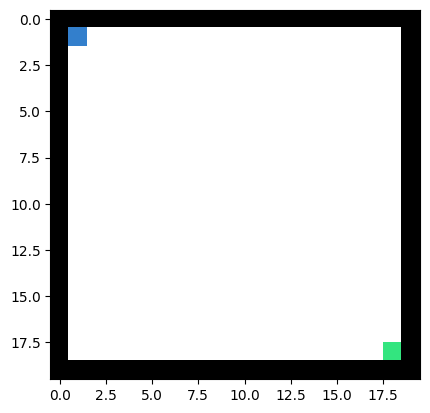

In [1]:
import numpy as np
from maze_simulator import TrafficMaze
import matplotlib.pyplot as plt
import imageio

mapa = """
####################
#o                 #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                  #
#                 x#
####################
"""

ent = TrafficMaze(mapa)
ent.draw()

### Heurística

Definimos entonces una heurística en base a la distancia, en donde podamos variar los valores (euclideana, Manhattan) a partir del parámetro $p$:

$$h(n) = \Big(|x_n - x_{goal}|^p+|y_n-y_{goal}|^p \Big)^{1/p}$$

Si $p=1$ tenemos la distancia Manhattan, y si $p=2$ tenemos la euclideana.

In [2]:
def heuristic(state, goal, p=2):
    """Función de heurística de distancia Minkowsky"""
    x,y = state
    x_goal, y_goal = goal
    distance = (abs(x - x_goal)**p + abs(y - y_goal)**p)**(1/p)
    
    return distance

### Funciones auxiliares

Definimos también clases para la pila de prioridad, para definir los nodos del árbol de búsqueda y finalmente definimos la función de expansión de cada nodo.

En la pila de prioridad consideramos la posibilidad de usar Beam Search, así si se le indica un número $k > 0$, se usará Beam Search con $k$ nodos. En otro caso, no se limitará la búsqueda.

De igual forma, en la expansión consideramos el método para determinar la función de prioridad. Así podremos variar entre los distintos métodos vistos.

In [3]:
class PriorityQueue(object):
    """Clase de una cola de prioridad en los problemas de búsqueda"""
    def __init__(self, k=None):
        self.queue = []
        self.size = k
  
    def __str__(self):
        return ' '.join([str(q) for q in self.queue])
  
    def isEmpty(self):
        return self.queue == []
  
    def push(self, element):
        if self.size == None:
            self.queue.append(element)
        else:
            if len(self.queue) >= self.size:
                for item in self.queue:
                    if item.f > element.f:
                        self.queue.remove(item)
                        self.queue.append(element)
                    else:
                        pass
            else:
                self.queue.append(element)        
  
    def pop(self):
        min_element = np.argmin([element.f for element in self.queue])
        item = self.queue[min_element]
        del self.queue[min_element]
    
        return item
    
    def top(self):
        min_element = np.argmin([element.f for element in self.queue])
        item = self.queue[min_element]
        
        return item
    
class Node(object):
    """Clase para crear nodos con sus atributos"""
    def __init__(self):
        self.state = None
        self.parent = None 
        self.action = None
        self.path_cost = 0
        self.depth = 0
        self.f = 0
        
    def __str__(self):
        return str(self.state)
    
def expand(problem, node, method='Astar',p=1):
    """Función para expandir los nodos dado el problema"""
    s = node.state
    for action in problem.actions(s):
        new_s = problem.result(s, action)
        
        new_node,new_node.state,new_node.parent,new_node.action = Node(),new_s,node,action
        new_node.depth = node.depth + 1
        new_node.path_cost = heuristic(new_s,problem.initial,p=2)
        if method == 'Astar':
            new_node.f = new_node.path_cost + heuristic(new_s,problem.goal,p=p)
        elif method == 'Dijkstra':
            new_node.f = new_node.path_cost
        elif method == 'Breadth':
            new_node.f = new_node.depth
        elif method == 'Depth':
            new_node.f = -new_node.depth
        else:
            print("No es algoritmo válido")
            
        yield new_node

Finalmente, definimos una serie de funciones auxiliares que nos permitirán visualizar los resultados que hemos obtenido. En particular, nos permitirán visualizar la forma en que cada algoritmo realiza la búsqueda de las soluciones.

In [4]:
from copy import deepcopy

def canvas2rgb_array(canvas):
    """Adapted from: https://stackoverflow.com/a/21940031/959926"""
    canvas.draw()
    buf = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    ncols, nrows = canvas.get_width_height()
    scale = round(np.sqrt(buf.size / 3 / nrows / ncols))
    return buf.reshape(scale * nrows, scale * ncols, 3)

def get_canvas(result, name='output'):
    steps = []
    board = deepcopy(ent.board)
    figure = plt.figure()
    plt.grid(linewidth=1)
    plt.ylim(20,-1)
    plt.xlim(-1,20)
    x_in, y_in = ent.initial
    x_g, y_g = ent.goal
    plt.scatter(x_in,y_in,c='r')
    plt.scatter(x_g,y_g,c='r')
    for node in result[1:-1]:
        x,y = node.state
        plt.scatter(x, y, c='b')
        steps.append(canvas2rgb_array(figure.canvas))
        
    imageio.mimsave(name+'.gif', steps)
    
    
def get_path(leaf, path=[]):
    """Función para recuperar el camino de un nodo"""
    if leaf.parent == None:
        return [leaf]+path
    else:
        return get_path(leaf.parent, path=[leaf]+path)
    
def get_solution(result): 
    """Muestra la solución"""
    ent_a = deepcopy(ent)
    for n in get_path(result[-1]):
        x,y = n.state
        ent_a.board[y][x] = 'o'

    ent_a.draw()

## Algoritmos de búsqueda

Definimos una función general que tomará en cuenta los siguientes parámetros:

1. <tt>method</tt>: Indica qué algoritmo se usará, consideramos los siguientes:
    1. Búsqueda en Profundidad
    2. Búsqueda en Amplitud
    3. Algoritmo de Dijkstra
    4. $A^*$
    5. Beam Search
2. <tt>p</tt>: Controla la heurística, si $p=1$ se usa Manhattan, si $p=2$ se usa euclideana. Se pueden probar otros valores, considerando que den valores reales. Sólo aplica en $A^*$.
3. <tt>beam</tt>: si en <tt>None</tt> No se usará Beam Search, si se escoge un $k>0$ se usará beam search. Se puede combinar con distintos algoritmos.

In [5]:
def search(problem, method, p=2, beam=None):
    """Algoritmos de búsqueda"""
    nodes = []
    node = Node()
    node.state = problem.initial
    frontier = PriorityQueue(k=beam)
    frontier.push(node)
    reached = {str(problem.initial):node}
 
    while frontier.isEmpty() == False:
        node = frontier.pop()
        nodes.append(node)
        if node.state == problem.goal:
            return nodes
        
        for child in expand(problem, node, method=method, p=p):
            state = child.state
            if str(state) not in reached.keys():
                reached[str(state)] = child
                frontier.push(child)

    print("No se ha logrado llegar a un estado final.")
    return nodes

# Algoritmos desinformados

## Algoritmo primero en profundidad

El algoritmo de primero en profundidad es quizá de los menos recomendados pues no se asegura que sea completo. En general, este algoritmo persiste en una acción, la más profunda, hasta que no puede realizarla más y realiza otra, pero entonces sigue persistiendo en la acción de nuevo, repitiendo este proceso hasta encontrar solución. En este caso, consideramos la función de prioridad como:

$$f(n) = -depth(n)$$

In [6]:
%%time
result_depth = search(ent, method='Depth')
print('Nodos de árbol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_depth), round(result_depth[-1].path_cost,2), result_depth[-1].depth ))

Nodos de árbol: 171
Costo solución: 24.04
Profundidad solución: 170
CPU times: user 12.8 ms, sys: 3.31 ms, total: 16.1 ms
Wall time: 14.8 ms


In [7]:
#get_canvas(result_depth,name='depth')

Vemos que la solución que encuentra es claramente no óptima, y que de hecho tiene a siempre hacer la acción hacia abajo hasta topar con pared, pasa a la siguiente acción y luego intenta de nuevo hacia arriba y de nuevo hacia abajo. Se realizan 170 pasos para llegar a la solución.

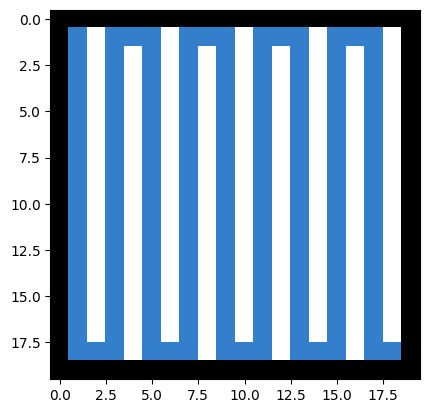

In [8]:
get_solution(result_depth)

El proceso de búsqueda se ilustra a continuación. Como vemos, en cada caso expande sólo el nodo que lo lleva hasta la solución, es decir, no está expandiendo más nodos de los necesarios para llegar a la solución. Pero de hecho, encuentra la solución más costosa de entre todos los algoritmos.

![image](images/depth.gif)

Resumimos las propiedades del algoritmo de primero en profundidad (b: índice de ramificación, m: profundidad máxima del árbol).

| Completo | Óptimo | Complejidad |
| --- | --- | --- |
| No | No | $O(b^m)$ |


## Algoritmo primero en amplitud

El algoritmo primero en amplitud expande primero los nodos de menor profundidad y de hecho expande todos los nodos antes de la profundidad de la solución. Aquí la función de prioridad está dada como:

$$f(n) = depth(n)$$

In [9]:
%%time
result_breadth = search(ent, method='Breadth')
print('Nodos de árbol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_breadth), round(result_breadth[-1].path_cost,2), result_breadth[-1].depth ))

Nodos de árbol: 324
Costo solución: 24.04
Profundidad solución: 34
CPU times: user 14 ms, sys: 13.3 ms, total: 27.2 ms
Wall time: 23.5 ms


En este caso, la solución expande muchos más nodos que primero en profundidad. Prácticamente explora todo el espacio de búsqueda. Pero la solución que tiene es más efectiva, pues sólo le toma 34 pasos llegar a la solución, por lo que tenemos una solución mejor que con búsqueda en profundidad.

In [10]:
#get_canvas(result_breadth,name='breadth')

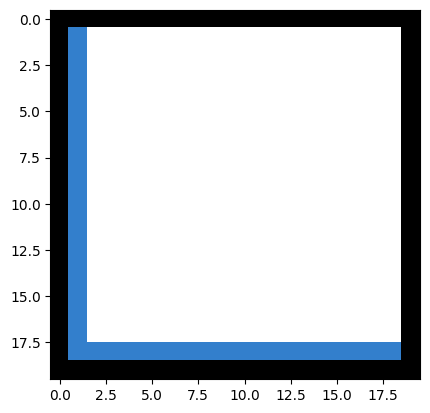

In [11]:
get_solution(result_breadth)

La solución toma esta forma porque de hecho podemos ver que, ya que estamos usando early goal test, el primer nodo que al expandir da la solución hace que el algoritmo se detenga, y este nodo es el que llega por la izquierda de la meta. También vemos que este algoritmo es el que explora más detalladamente el espacio de búsqueda, por lo que tiene el problema de su complejidad. Aunque tiene la ventaja de que sí es completo.

![image](images/breadth.gif)

Resumimos las características del algoritmo de primero en amplitud (b: índice de ramificación, d: profundidad de la solución):

| Completo | Óptimo | Complejidad |
| --- | --- | --- |
| Sí | No | $O(b^d)$ |

## Algoritmo de Dijkstra

El algoritmo de Dijkstra busca los caminos de menor costo, por lo que la función de prioridad está dada como:

$$f(n) = g(n)$$

Donde $g(n)$ es el costo.

In [12]:
%%time
result_dijks = search(ent, method='Dijkstra')
print('Nodos de árbol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_dijks), round(result_dijks[-1].path_cost,2), result_dijks[-1].depth ))

Nodos de árbol: 324
Costo solución: 24.04
Profundidad solución: 34
CPU times: user 20.8 ms, sys: 603 µs, total: 21.4 ms
Wall time: 19.3 ms


En este caso, la solución que obtenemos es óptima, que de hecho consiste en 34 pasos (igual que la de búsqueda en amplitud); sin embargo, vemos que la complejidad es también la misma que en amplitud. Este algoritmo, expande casi todo el espacio de búsqueda.

In [13]:
#get_canvas(result_dijks, name='dijkstra')

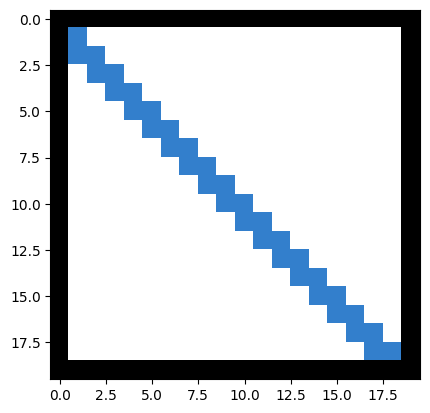

In [14]:
get_solution(result_dijks)

La solución difiere a la de primero en amplitud, a pesar de expandir los mismo nodos y que la solución sea de la misma longitud. Esto se debe a la forma en que se hace la búsqueda, pues como lo hace mediante el costo, puede llegar a expandir todos los nodos, pero siempre desde el camino de menor costo:

![image](images/dijkstra.gif)

Resumimos las características del algoritmo de primero en amplitud (b: índice de ramificación, $C^*$: costo de la solución óptima):

| Completo | Óptimo | Complejidad |
| --- | --- | --- |
| Sí | Sí | $O(b^{1+\lfloor C^*/\epsilon \rfloor})$ |


# Algoritmos informados

## Algoritmo $A^*$

El algoritmo $A^*$ es el algoritmo de búsqueda heurística por excelencia. Este se basa en una función heurística $h:V\to \mathbb{R}$ que nos informa qué tan lejos estamos de la meta. Su función está dada por:

$$f(n) = g(n) + h(n)$$

Donde $g(n)$ es el costo y $h(n)$ es la heurística. Es un algoritmo completo, sin embargo, es óptimo si la heurística es admisible; esto es, si $h$ cumple que para toda $n$: 

$$h(n) \leq h^*(n)$$

Donde $h^*(n)$ es la heurística óptima. Además, su complejidad dependerá también de la heurística. Es decir, tenemos que:

| Completo | Óptimo | Complejidad |
| --- | --- | --- |
| Sí | Depende de $h$ | Depende de $h$ |

#### Heurística euclideana

Con la heurística de la distancia euclideana, el algoritmo si es óptimo, pues se trata de una heurística admisible, sin embargo, no es la óptima.

In [15]:
%%time
result_a = search(ent, method='Astar',p=2)
print('Nodos de árbol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_a), round(result_a[-1].path_cost,2), result_a[-1].depth ))

Nodos de árbol: 75
Costo solución: 24.04
Profundidad solución: 34
CPU times: user 0 ns, sys: 6.2 ms, total: 6.2 ms
Wall time: 6.12 ms


Llega a la solución óptima de 34 pasos, y expande sólo 75 nodos, pues nuestra heurística está muy cercana a la óptima. Por lo que la complejidad, comparada con los algoritmos anteriores se reduce mucho.

In [16]:
#get_canvas(result_a,name='astar')

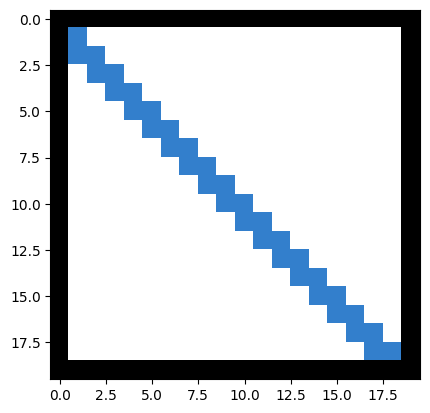

In [17]:
get_solution(result_a)

Sin embargo, como lo señalamos, la heurística no es óptima. Vemos que, si bien, tiende a expandir en su mayoría nodos del camino óptimo, no siempre lo hace.

![image](images/astar.gif)

#### Heurística Manhattan

Al usar la heurística Manhattan obtenemos una heurística admisible que domina sobre la euclideana. Esto es, para toda $n$:

$$h_{euc}(n) \leq h_{manh}(n)$$

Es más, se trata de una heurística óptima.

In [18]:
%%time
result_man = search(ent, method='Astar',p=1)
print('Nodos de árbol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_man), round(result_man[-1].path_cost,2), result_man[-1].depth ))

Nodos de árbol: 35
Costo solución: 24.04
Profundidad solución: 34
CPU times: user 0 ns, sys: 2.92 ms, total: 2.92 ms
Wall time: 2.84 ms


In [19]:
#get_canvas(result_man,name='astarManh')

Notamos que el número de nodos expandidos se corresponde al los pasos del camino óptimo (más el inicial), por eso garantizamos que es una heurística óptima.

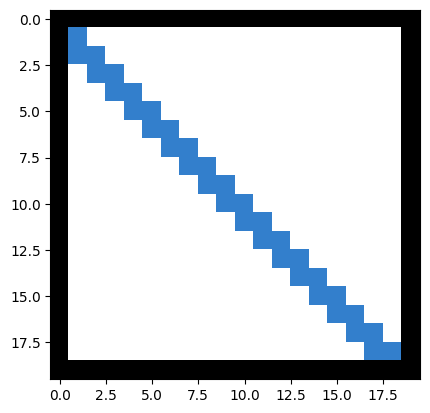

In [20]:
get_solution(result_man)

De hecho, observamos que sólo expande nodos que están en este camino, por lo que su complejidad es lineal sobre la profundidad de la solución óptima, $O(d)$. No siempre será fácil encontrar heurísticas óptimas, pero hemos construido el problema de tal forma que conocemos de antemano esto.

![image](images/astarManh.gif)


## Beam Search

La búsqueda por haz o Beam Search es un método de búsqueda que acota los nodos expandidos en cada iteración con base a su prioridad. De esta forma, en cada paso sólo toma $k$ nodos en la frontera que corresponden a los nodos con mayor prioridad.

In [21]:
%%time
result_beam = search(ent, method='Astar', p=2, beam=3)
print('Nodos de ábol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_beam), round(result_beam[-1].path_cost,2), result_beam[-1].depth ))

Nodos de ábol: 48
Costo solución: 24.04
Profundidad solución: 34
CPU times: user 3.18 ms, sys: 3.21 ms, total: 6.39 ms
Wall time: 6.11 ms


Como se puede observar, los nodos expandidos con Beam Search son menos que los expandidos solo con $A^*$ de heurística euclideana, pues acotamos la expansión a sólo 3 nodos por iteración. En este caso, la solución encontrada sigue siendo óptima.

In [22]:
#get_canvas(result_beam,name='beam')

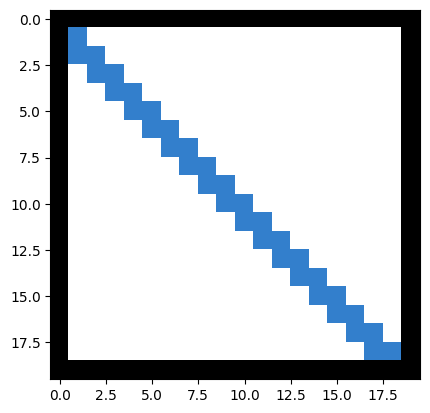

In [23]:
get_solution(result_beam)

Si bien la solución es la misma que sin Beam Search, el proceso se hace de manera más rápida, pues no se consideran tantos nodos en la frontera.

![image](images/beam.gif)

Podemos ver que de hecho la complejidad de Beam Search es de $O(kd)$, donde $k$ es el parámetro de máximo números expandidos por iteración y $d$ es la profundidad de la solución.

Sin embargo, el que el algoritmo sea complejo u óptimo depende en general de $k$ y del tipo de estrategia de búsqueda que se use, pues un valor muy pequeño podría hacer que no se converja a una solución, que no sea completo, o bien que no sea óptimo. 

Por ejemplo, podemos limitar la búsqueda con el algoritmo de Dijkstra:

In [24]:
%%time
result_beamD = search(ent, method='Dijkstra', beam=3)
print('Nodos de ábol: {}\nCosto solución: {}\nProfundidad solución: {}'.format( len(result_beam), round(result_beam[-1].path_cost,2), result_beam[-1].depth ))

Nodos de ábol: 48
Costo solución: 24.04
Profundidad solución: 34
CPU times: user 12 ms, sys: 12 ms, total: 24 ms
Wall time: 20.5 ms


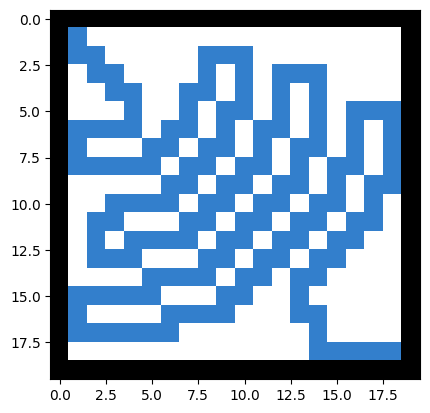

In [25]:
#get_canvas(result_beamD,name='beamdijks')
get_solution(result_beamD)

Si bien el número de nodos que expande es mucho menor a usar el algoritmo de Dijkstra sin límite de los nodos de expansión, vemos sin embargo que la solución no es óptima. De hecho, la búsqueda qué hace, sólo con la información del costo, se desvía en general del camino óptimo.

![image](images/beamdijks.gif)

### Conclusiones

En general, los algoritmos revisados tienen ciertas ventajas y desventajas. Pero el que muestra mejor desempeño es el algoritmo de $A^*$ principalmente cuando su heurística es óptima o cercana a la óptima. Sin embargo, no siempre se puede encontrar una heurística de este tipo, sobre todo cuando nuestros entornos son más complejos (como parcialmente observables, dinámicos, etc.); en estos casos, según la información que se cuente se puede usar un algoritmo de búsqueda desinformada.

Los algoritmos como Beam Search también se utilizan bastantes para diferentes tareas, pues permiten acostar la búsqueda a los mejores resultados. Esto hace más eficiente el procesamiento sobre todo cuando se tiene un número grande de datos.